In [30]:
import os

from transformers import AutoTokenizer, AutoModel
import sqlite3
import pandas as pd
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

REPORT_DB_PATH = "/pub4/data/czhao/reports.db"

model_name = 'medicalai/ClinicalBERT'

result_dir = "/pub4/data/czhao/eeg_results/clustering/"
os.makedirs(result_dir, exist_ok=True)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


In [31]:

def db_iterator(db_path):
    """
    Iterate over the database and yield each report
    """
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    query = "SELECT `Hashed ID`, `Report`, `Norm(1)/No(0)` FROM reports"
    try:
        cursor.execute(query)
        # Fetch rows one by one
        while True:
            row = cursor.fetchone()
            if row is None:
                break
            yield row
    except sqlite3.Error as e:
        print(f"SQLite error: {e}")
        yield None
    finally:
        conn.close()

def get_label_setup(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    def get_label(hashid):
        query = f"SELECT `Norm(1)/No(0)` FROM reports WHERE `Hashed ID` = '{hashid}'"
        cursor.execute(query)
        return cursor.fetchone()[0]
    
    return get_label

def get_ground_truth_list(count=100):
    """
    Get the ground truth list
    """
    ground_truth_list = []
    for row in db_iterator(REPORT_DB_PATH):
        if count == 0:
            break
        ground_truth_list.append(row[2])
        count -= 1
    return ground_truth_list

In [3]:
count = 100

# Iterate over the first 100 reports
min = float("inf")
max = float("-inf")
l= []

for hashed_id, report, normal in db_iterator(REPORT_DB_PATH):
    report = clean_text(report)

    with torch.no_grad():
        inputs = tokenizer(report, return_tensors="pt", padding=True, truncation=True)
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        
        reshaped = last_hidden_states.mean(dim=1).squeeze(0) #.view(-1, 32)

        l.append((reshaped, hashed_id))
        if reshaped.min().item() < min:
            min = reshaped.min().item()
        if reshaped.max() > max:
            max = reshaped.max().item()
        # reshaped = (reshaped - reshaped.min()) / (reshaped.max() - reshaped.min())

    count -= 1
    if count == 0:
        break
print(min, max)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


-2.3199682235717773 1.2097758054733276


In [6]:
dfs = []
n_components = [64, 100]

In [7]:
stacked_tensor = torch.stack([x[0] for x in l])
stacked_tensor = stacked_tensor.numpy()
stacked_tensor.shape

file_name = "bert_output_768"

with open(file_name + ".csv", "w") as f:
    f.write("\n")
    for i, (_, __) in enumerate(l):
        reshaped = stacked_tensor[i]
        f.write(str(reshaped.tolist())[1:-1].replace(" ", "") + "\n")

NameError: name 'l' is not defined

In [15]:
x = StandardScaler().fit_transform(stacked_tensor)

# PCA
for n in n_components:
    file_name = "bert_output_pca_" + str(n)
    
    pca = PCA(n_components=n)
    
    principalComponents = pca.fit_transform(x)
    principalComponents.shape

    with open(file_name + ".csv", "w") as f:
        f.write("\n")
        for i, (_, __) in enumerate(l):
            reshaped = principalComponents[i]
            f.write(str(reshaped.tolist())[1:-1].replace(" ", "") + "\n")

In [20]:
os.chdir("./FuzzyJMeansVNS")
from FuzzyJMeansVNS.fvjm import fit

os.chdir("..")

result_dict = {}
fz_factors = [1.25,1.5,1.75,2.0]

In [29]:
file_names = ["bert_output_768.csv"]
for n in n_components:
    file_names.append("bert_output_pca_" + str(n) + ".csv")
for n in n_components:
    file_names.append("bert_output_svd_" + str(n) + ".csv")

for (i, f) in enumerate(file_names):
    for fz in fz_factors:
        f_name = result_dir + "result_" + f[12:].replace(".csv", "") + "_" + str(fz) + ".csv"
        if (os.path.exists(f_name)):
            continue
        df = pd.read_csv(result_dir + f, header=None)
        result_dict[(i, fz)] = fit(df, fz, fuzzy_factor=fz)
        result_dict[(i, fz)].to_csv(f_name)

In [14]:
get_label = get_label_setup(REPORT_DB_PATH)

In [36]:
import seaborn as sn

def plot_2d_chart_with_different_fz(origin_embeddings, df_membership_dict):
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))

    pca =  PCA(n_components=2)
    x_pca = pca.fit_transform(origin_embeddings)

    for i, (fz, membership) in enumerate(df_membership_dict.items()):
        axs[i//2, i%2].set_xlabel("PC 1")
        axs[i//2, i%2].set_ylabel("PC 2")

        axs[i//2, i%2].set_title(f"Fuzzy Clusters with Fuzzy Factor = {fz}")
        scatter = axs[i//2, i%2].scatter(x_pca[:, 0], x_pca[:, 1], c=membership.iloc[:, 2], cmap='viridis', edgecolor='k')
        legend = axs[i//2, i%2].legend(*scatter.legend_elements(), title="Clusters")
        axs[i//2, i%2].add_artist(legend)

def plot_2d_charts(origin_embeddings, df_membership, ground_truth, fig_name):
    """
    Args: 
    origin_embeddings: (100, 768)
    df_membership: (100, 3) df
    ground_truth: (100,)
    """
    # 3 subplots
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Apply pca to the original embeddings
    pca = PCA(n_components=2)
    x_pca = pca.fit_transform(origin_embeddings)

    for i in range(3):
        axs[i].set_xlabel("Principal Component 1")
        axs[i].set_ylabel("Principal Component 2")

    # Plot the original embeddings colored with ground truth
    axs[0].set_title("Ground Truth")
    ground_truth = [1 if x == 1 else 2 for x in ground_truth]
    scatter = axs[0].scatter(x_pca[:, 0], x_pca[:, 1], c=ground_truth, cmap='viridis', edgecolor='k')
    legend = axs[0].legend(*scatter.legend_elements(), title="Classes")
    axs[0].add_artist(legend)

    # Ground the index of embeddings based on the clusters
    cluster_dict = {}
    for i in range(1,3):
        cluster_dict[i] = []
        for j in range(100):
            if df_membership.iloc[j, 2] == i:
                cluster_dict[i].append(j)
    # Find the centroid of each cluster
    centroids = []
    for i in range(1,3):
        cluster = cluster_dict[i]
        centroid = np.mean(x_pca[cluster], axis=0)
        centroids.append(centroid)
    centroids = np.array(centroids)
    
    # Plot the original embeddings with color representing the cluster
    axs[1].set_title("Fuzzy Clusters")
    scatter = axs[1].scatter(x_pca[:, 0], x_pca[:, 1], c=df_membership.iloc[:, 2], cmap='viridis', edgecolor='k')
    axs[1].scatter([x[0] for x in centroids], [x[1] for x in centroids], c='red', s=100, alpha=1, marker='x') # Plot the centroids
    legend = axs[1].legend(*scatter.legend_elements(), title="Clusters")
    axs[1].add_artist(legend)

    # Plot the embeddings with intermediately colored clusters
    df_copy = df_membership.copy()
    axs[2].set_title("Fuzzy Membership")
    scatter = axs[2].scatter(x_pca[:, 0], x_pca[:, 1], c=df_copy.iloc[:, 1], cmap='viridis', edgecolor='k')
    axs[2].scatter([x[0] for x in centroids], [x[1] for x in centroids], c='red', s=100, alpha=1, marker='x') # Plot the centroids
    legend = axs[2].legend(*scatter.legend_elements(), title="Membership")
    axs[2].add_artist(legend)

    # Plot the confusion matrix
    axs[3].set_title("Confusion Matrix")
    confusion_matrix = np.zeros((2,2))
    for i in range(100):
        if df_membership.iloc[i, 2] == 1:
            if ground_truth[i] == 1:
                confusion_matrix[0,0] += 1
            else:
                confusion_matrix[0,1] += 1
        else:
            if ground_truth[i] == 1:
                confusion_matrix[1,0] += 1
            else:
                confusion_matrix[1,1] += 1
    df_cm = pd.DataFrame(confusion_matrix, index = ["Normal", "Abnormal"],
                        columns = ["1", "2"])
    sn.heatmap(df_cm, annot=True, ax=axs[3])
    sn.set(font_scale=1)
    axs[3].set_xlabel("Predicted")
    axs[3].set_ylabel("Ground Truth")

    fig.suptitle(fig_name, fontsize=16)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.savefig(result_dir + fig_name.replace(" ", "_").replace("=", "_") + ".png")

def plot_2d_charts_with_mixed(origin_embeddings, df_membership, ground_truth, fig_name):
    """
    Args: 
    origin_embeddings: (100, 768)
    df_membership: (100, 3) df
    ground_truth: (100,)
    """
    # 3 subplots
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Apply pca to the original embeddings
    pca = PCA(n_components=2)
    x_pca = pca.fit_transform(origin_embeddings)

    for i in range(3):
        axs[i].set_xlabel("Principal Component 1")
        axs[i].set_ylabel("Principal Component 2")

    # Plot the original embeddings colored with ground truth
    axs[0].set_title("Ground Truth")
    ground_truth = [1 if x == 1 else 2 for x in ground_truth]
    scatter = axs[0].scatter(x_pca[:, 0], x_pca[:, 1], c=ground_truth, cmap='viridis', edgecolor='k')
    legend = axs[0].legend(*scatter.legend_elements(), title="Classes")
    axs[0].add_artist(legend)

    # Group the the mixed class based on the first 2 columns of the membership matrix
    # Iterate the membership df
    for i in range(100):
        if df_membership.iloc[i, 1] > 0.4 and df_membership.iloc[i, 1] < 0.6:
            # Set the label to 0
            df_membership.iloc[i, 2] = 0

    # Ground the index of embeddings based on the clusters
    cluster_dict = {}
    for i in range(3):
        cluster_dict[i] = []
        for j in range(100):
            if df_membership.iloc[j, 2] == i:
                cluster_dict[i].append(j)
    # Find the centroid of each cluster
    centroids = []
    for i in range(3):
        cluster = cluster_dict[i]
        centroid = np.mean(x_pca[cluster], axis=0)
        centroids.append(centroid)
    centroids = np.array(centroids)
    
    # Plot the original embeddings with color representing the cluster
    axs[1].set_title("Fuzzy Clusters")
    scatter = axs[1].scatter(x_pca[:, 0], x_pca[:, 1], c=df_membership.iloc[:, 2], cmap='viridis', edgecolor='k')
    axs[1].scatter([x[0] for x in centroids], [x[1] for x in centroids], c='red', s=100, alpha=1, marker='x') # Plot the centroids
    legend_elements = scatter.legend_elements()
    legend_elements[1][0] = "mixed"
    legend = axs[1].legend(*legend_elements, title="Clusters")
    axs[1].add_artist(legend)

    # Plot the embeddings with intermediately colored clusters
    df_copy = df_membership.copy()
    axs[2].set_title("Fuzzy Membership")
    scatter = axs[2].scatter(x_pca[:, 0], x_pca[:, 1], c=df_copy.iloc[:, 1], cmap='viridis', edgecolor='k')
    axs[2].scatter([x[0] for x in centroids], [x[1] for x in centroids], c='red', s=100, alpha=1, marker='x') # Plot the centroids
    legend = axs[2].legend(*scatter.legend_elements(), title="Membership")
    axs[2].add_artist(legend)

    # Plot the confusion matrix
    axs[3].set_title("Confusion Matrix")
    confusion_matrix = np.zeros((2,3))
    for i in range(100):
        if df_membership.iloc[i, 2] == 1:
            if ground_truth[i] == 1:
                confusion_matrix[0,0] += 1
            else:
                confusion_matrix[0,2] += 1
        elif df_membership.iloc[i, 2] == 2:
            if ground_truth[i] == 1:
                confusion_matrix[1,0] += 1
            else:
                confusion_matrix[1,2] += 1
        else:
            if ground_truth[i] == 1:
                confusion_matrix[0,1] += 1
            else:
                confusion_matrix[1,1] += 1
    df_cm = pd.DataFrame(confusion_matrix, index = ["Normal", "Abnormal"],
                        columns = ["1","mixed", "2"])
    sn.heatmap(df_cm, annot=True, ax=axs[3])
    sn.set(font_scale=1)
    axs[3].set_xlabel("Predicted")
    axs[3].set_ylabel("Ground Truth")

    fig.suptitle(fig_name, fontsize=16)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.savefig(result_dir + fig_name.replace(" ", "_").replace("=", "_") + ".png")

In [25]:
pd.read_csv(result_dir + "result_pca_100_2.0.csv", index_col=0)
pd.read_csv(result_dir + "bert_output_768")


1         2  label
0   0.278633  0.721367      2
1   0.682549  0.317451      1
2   0.384129  0.615871      2
3   0.416103  0.583897      2
4   0.353676  0.646324      2
..       ...       ...    ...
95  0.570768  0.429232      1
96  0.600462  0.399538      1
97  0.438590  0.561410      2
98  0.484269  0.515731      2
99  0.428299  0.571701      2

[100 rows x 3 columns]

In [28]:
pd.read_csv(result_dir + "result_pca_100_2.0.csv", index_col=0)
pd.read_csv(result_dir + "bert_output_768.csv", header=None).to_numpy()

array([[-0.2976042 , -0.17303683,  0.57011986, ...,  0.37450206,
         0.2986356 , -0.61895913],
       [-0.33683226, -0.16381511,  0.50049716, ...,  0.29304406,
         0.26020563, -0.4448857 ],
       [-0.2988314 , -0.22743213,  0.54117048, ...,  0.28390351,
         0.24139674, -0.60992789],
       ...,
       [-0.24463807, -0.15328762,  0.56679291, ...,  0.29965138,
         0.36510313, -0.55710495],
       [-0.2698099 , -0.11936299,  0.51830536, ...,  0.39565969,
         0.21915533, -0.53164011],
       [-0.2376474 , -0.11549404,  0.56398708, ...,  0.31753182,
         0.26115856, -0.48098093]])

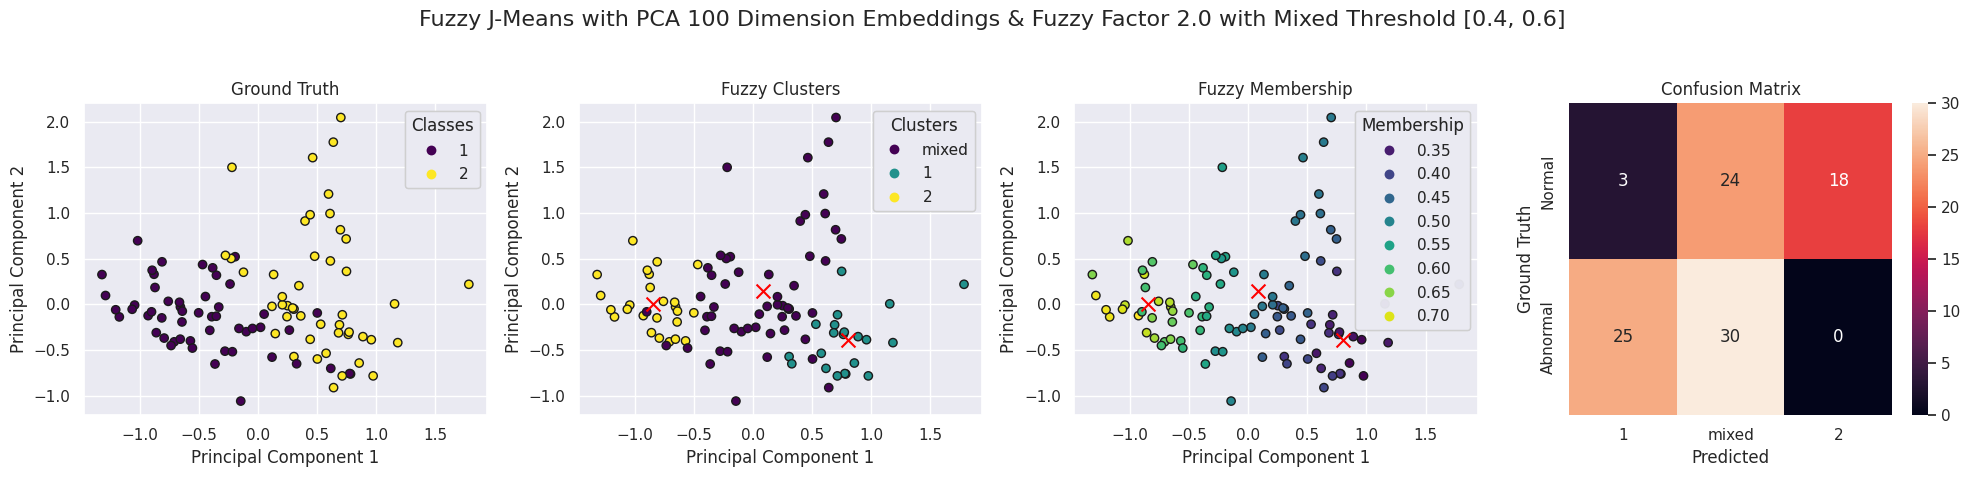

In [41]:
df_membership = pd.read_csv(result_dir + "result_pca_100_2.0.csv", index_col=0)
plot_2d_charts_with_mixed(stacked_tensor, df_membership, get_ground_truth_list(), "Fuzzy J-Means with PCA 100 Dimension Embeddings & Fuzzy Factor 2.0 with Mixed Threshold [0.4, 0.6]")

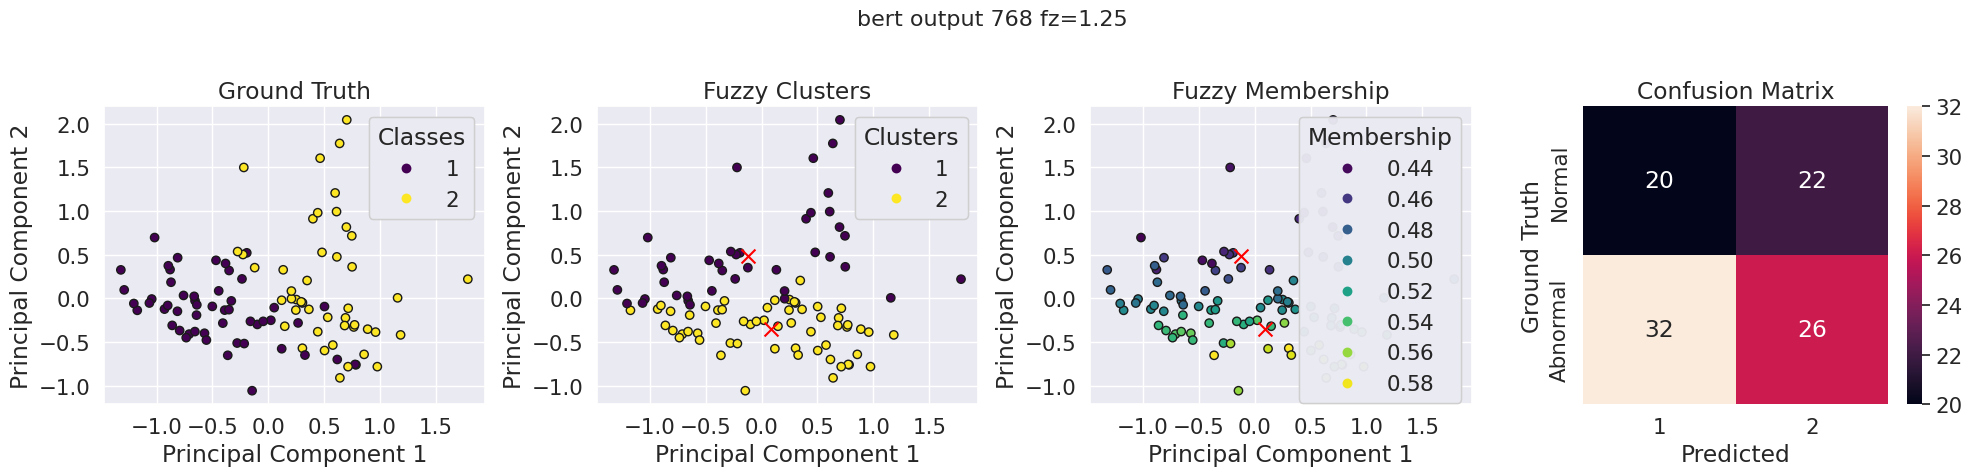

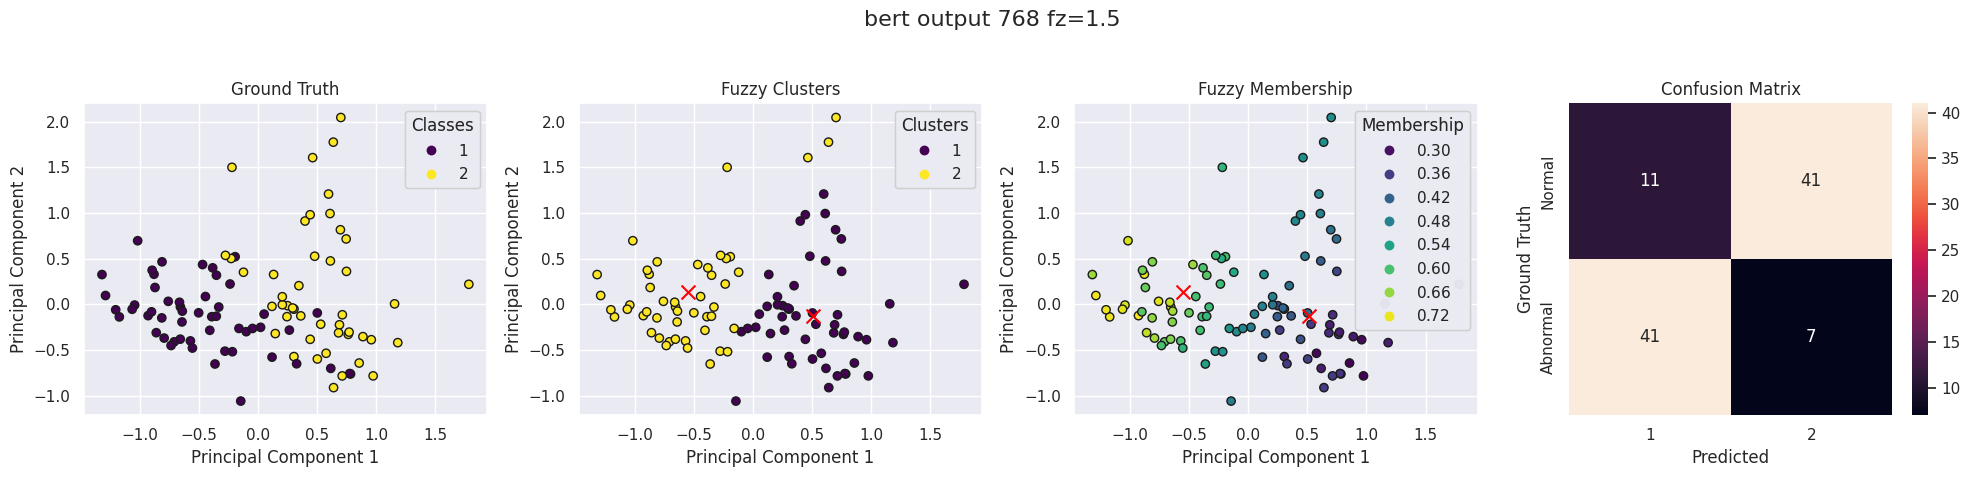

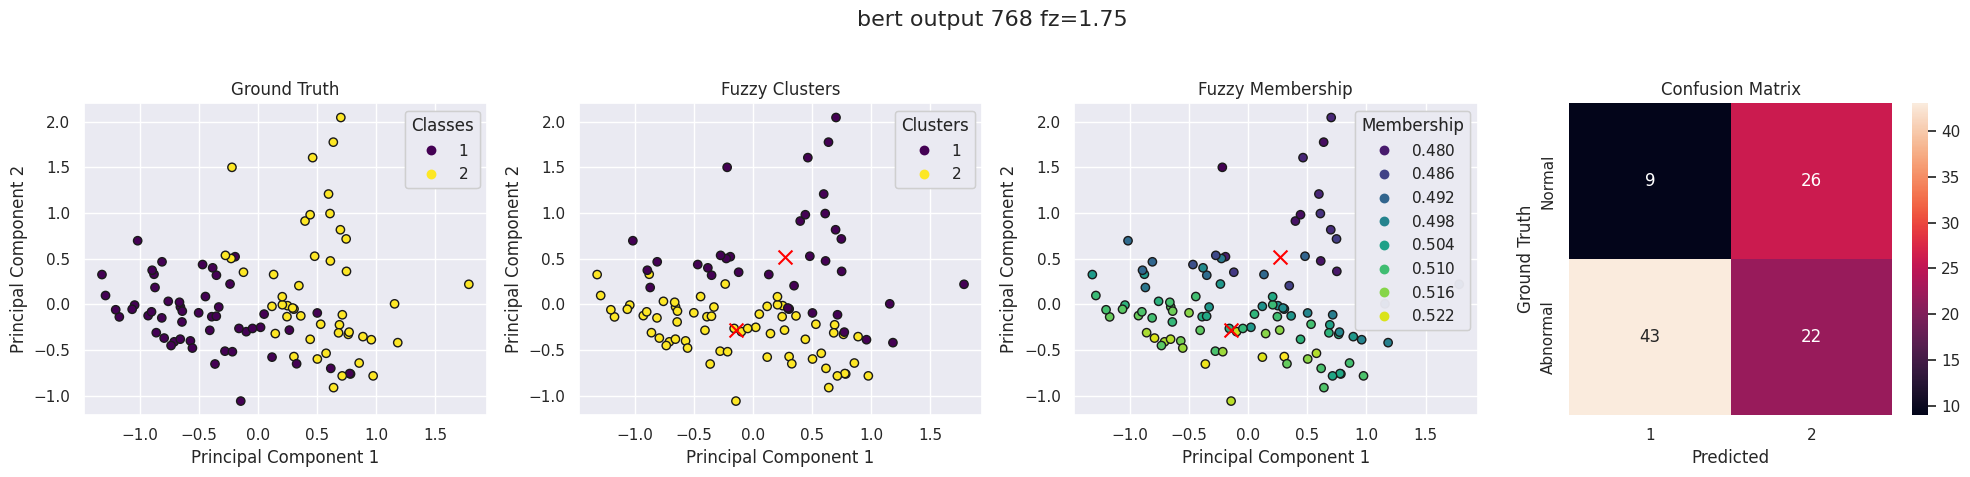

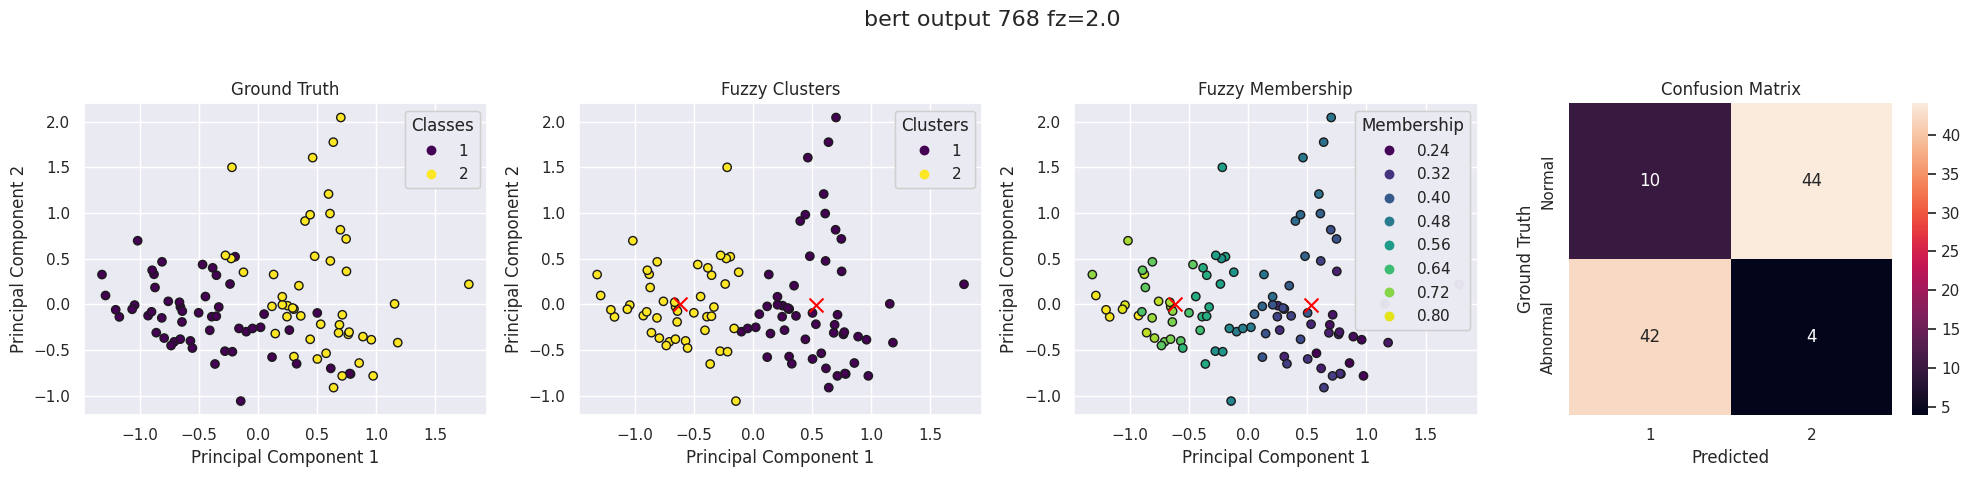

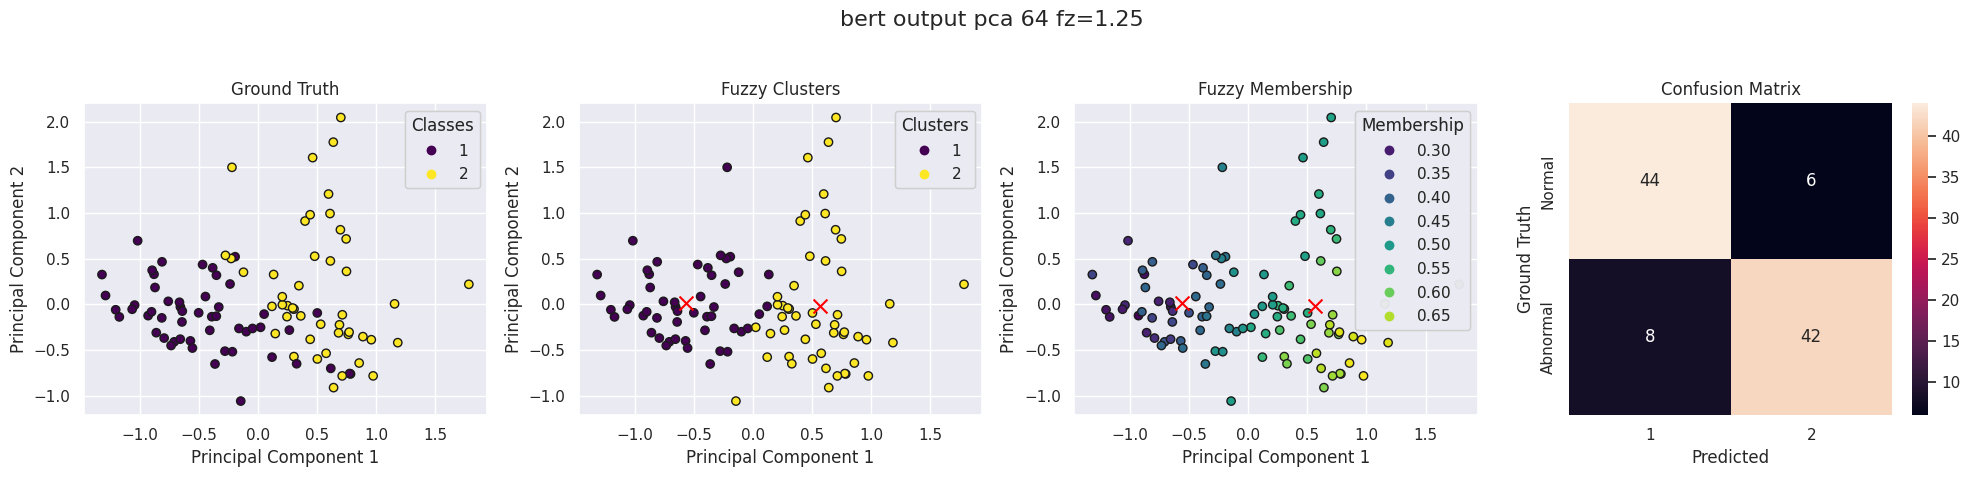

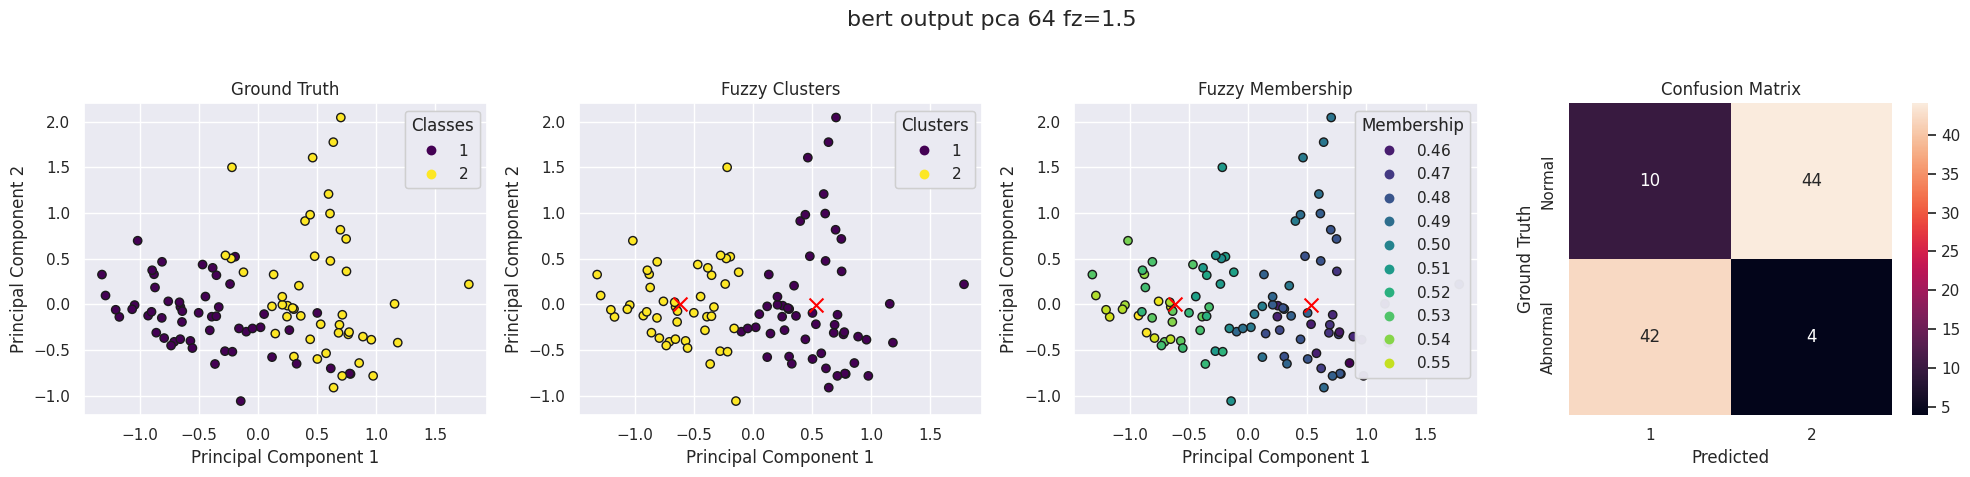

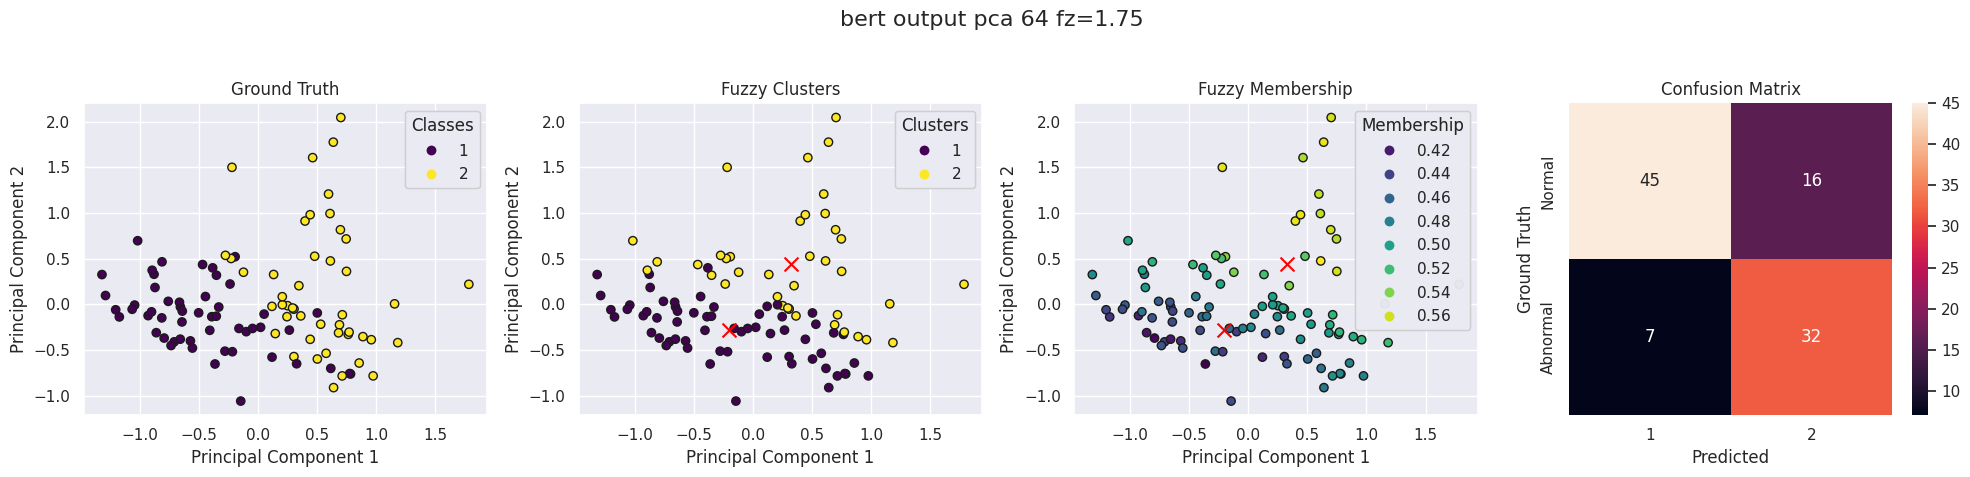

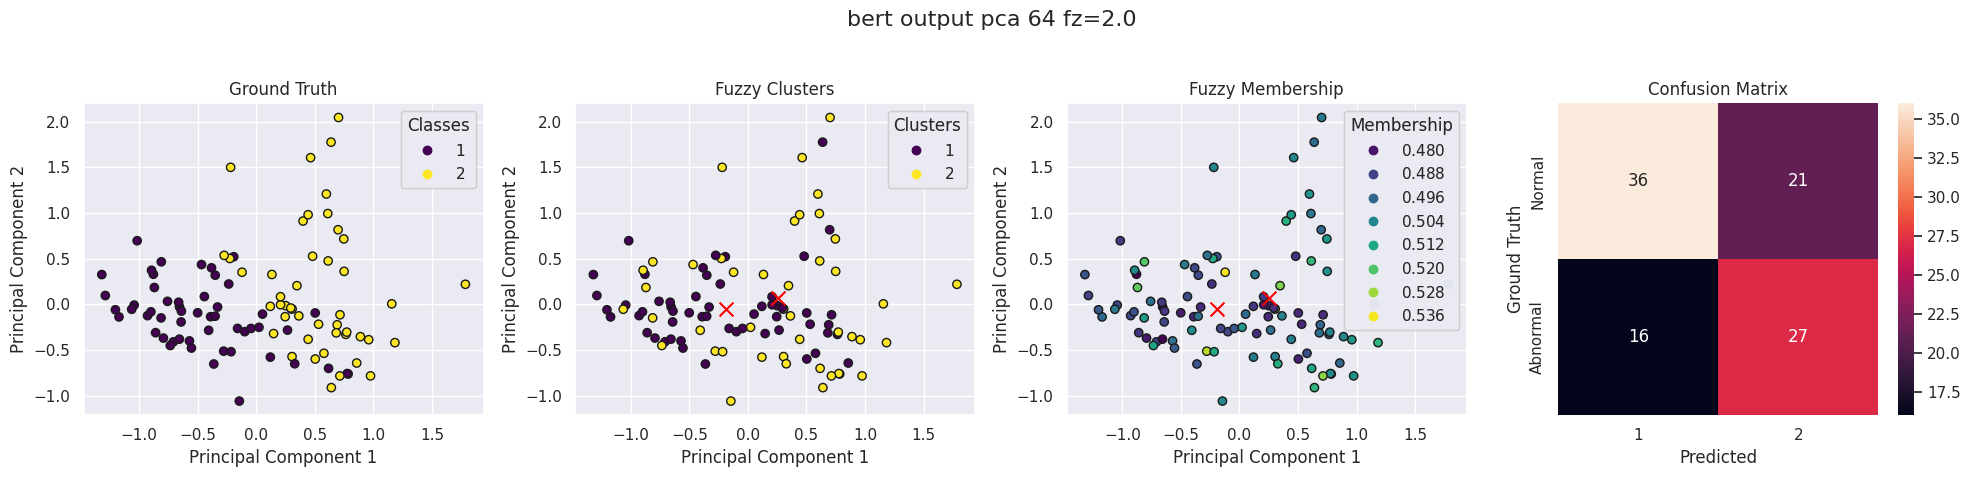

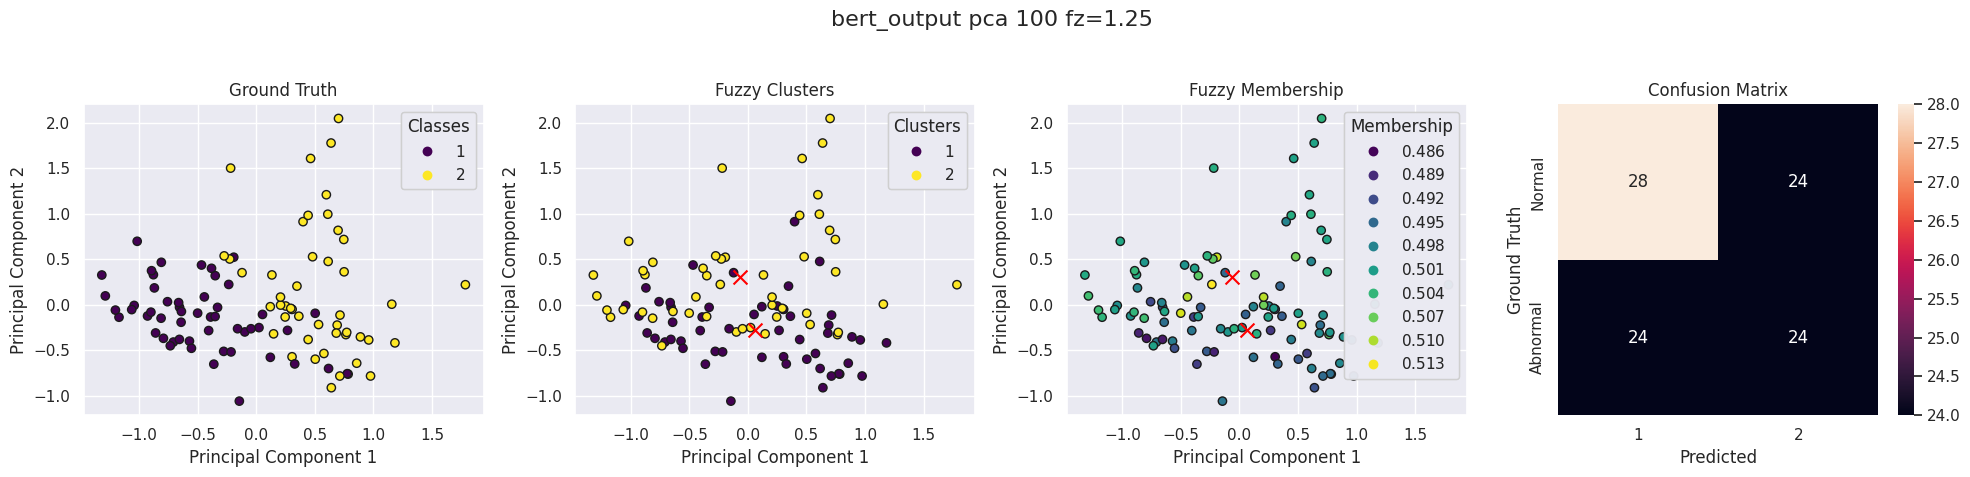

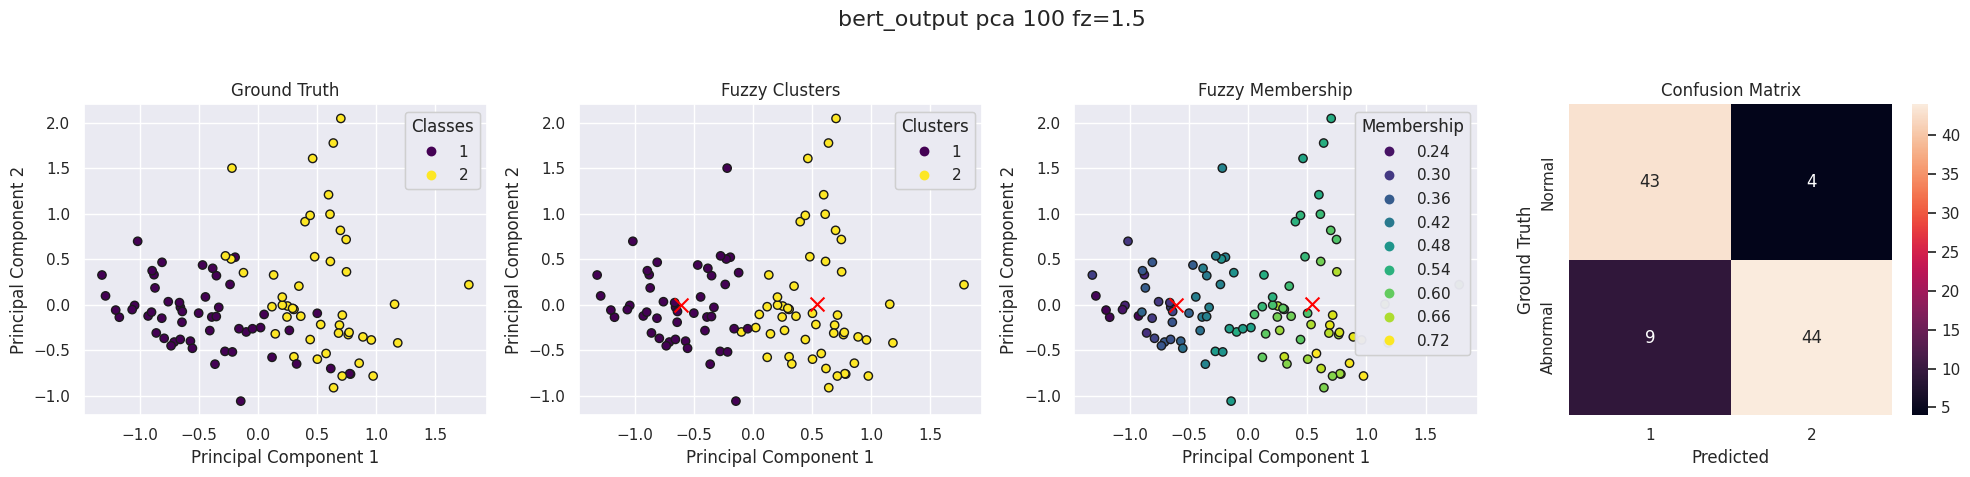

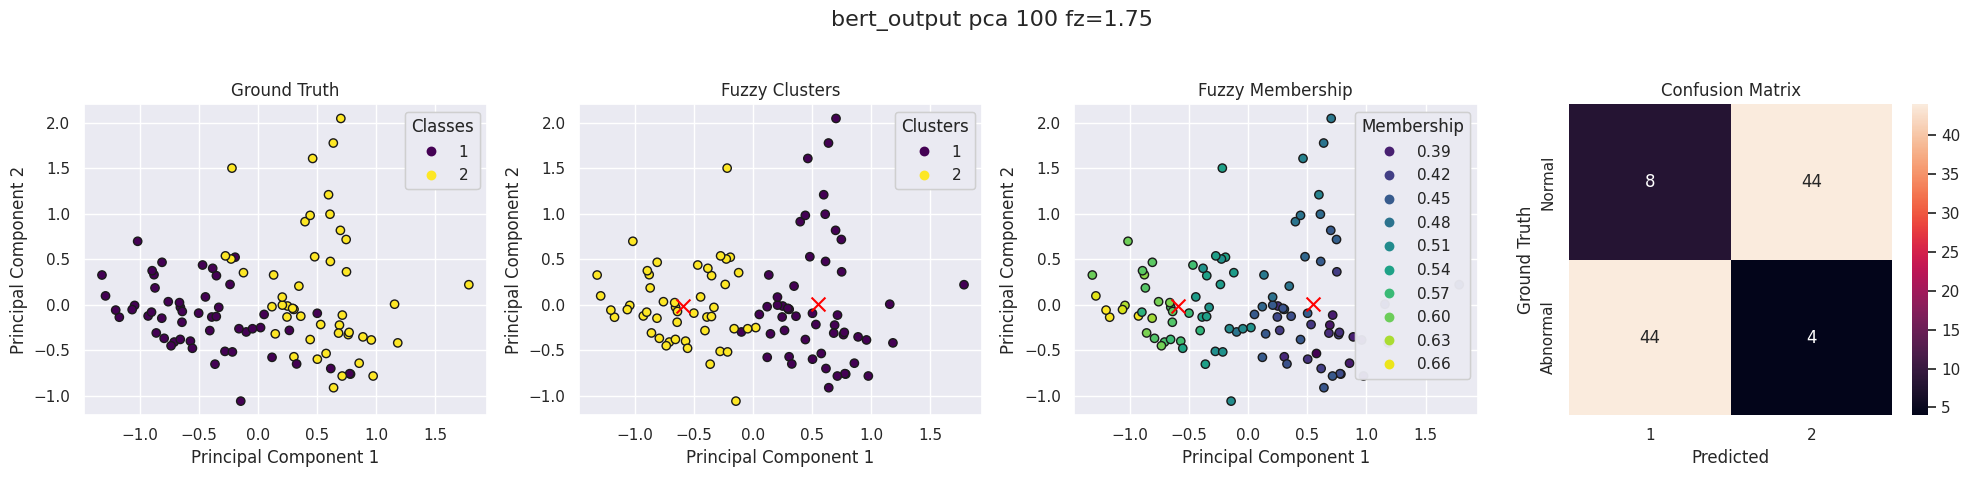

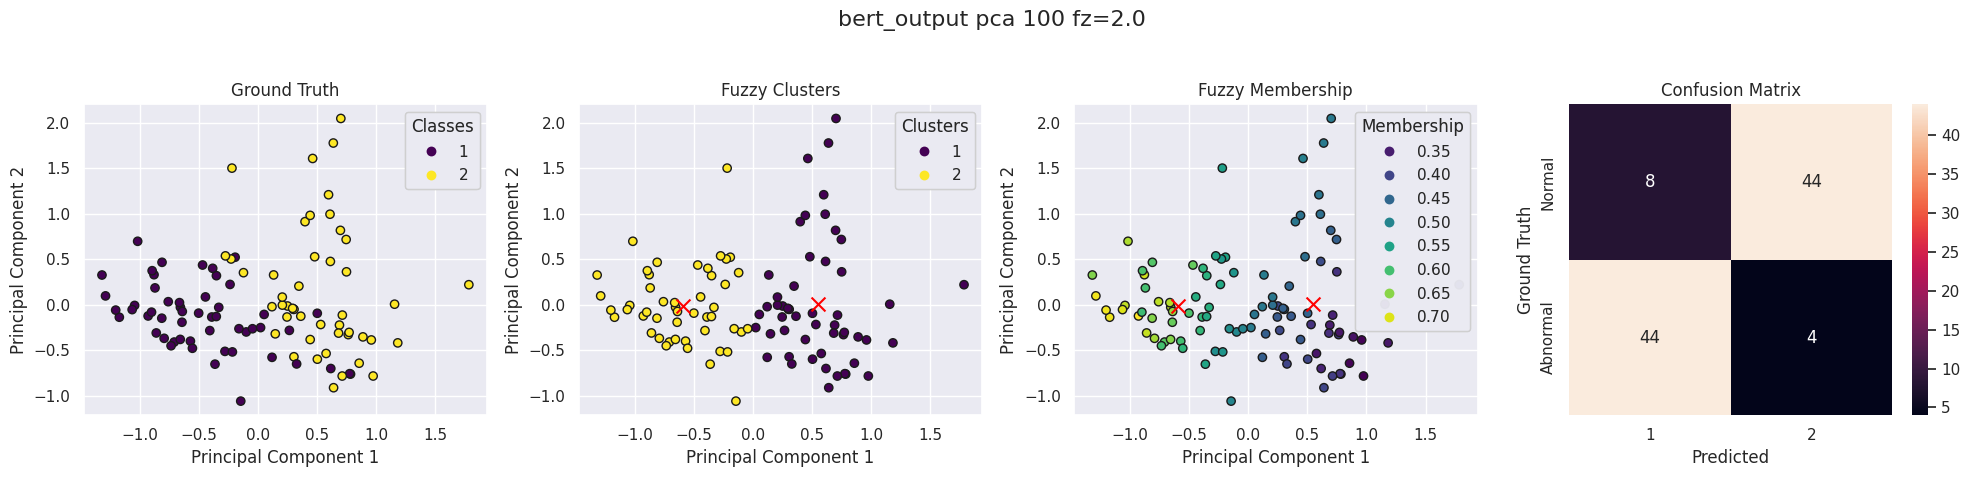

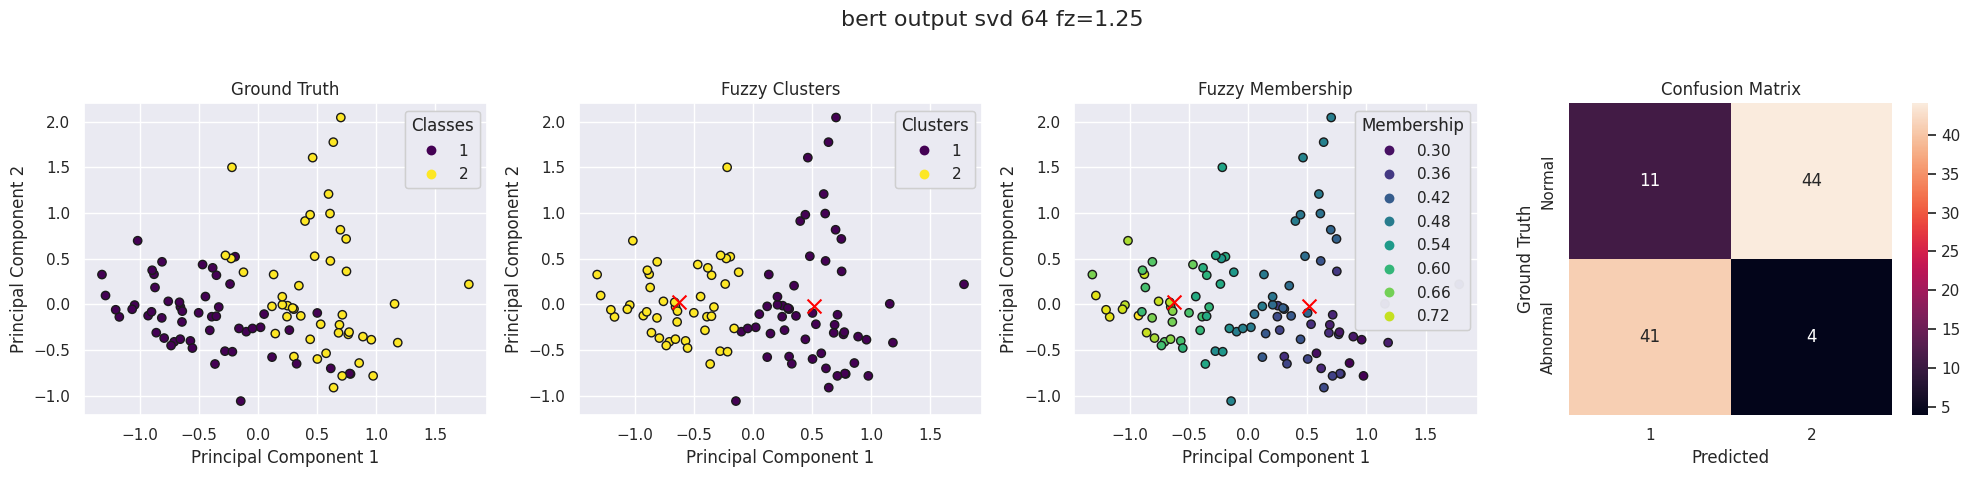

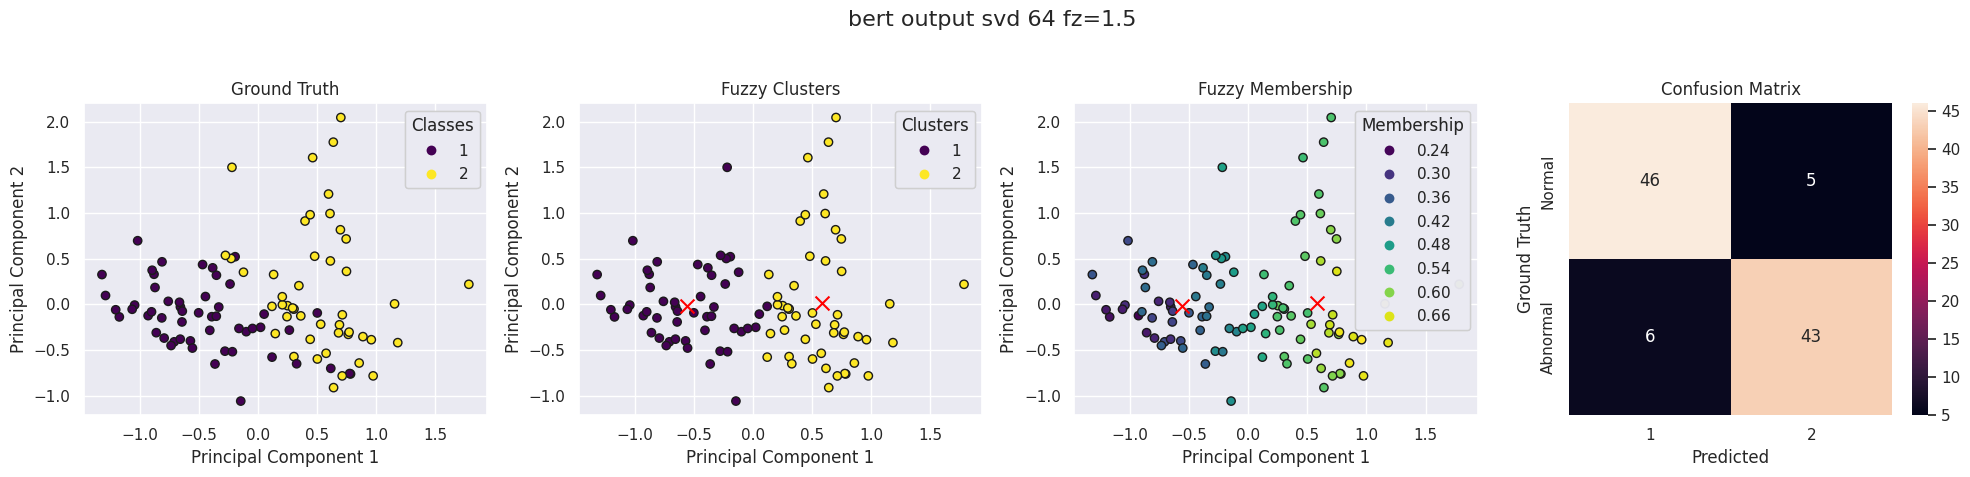

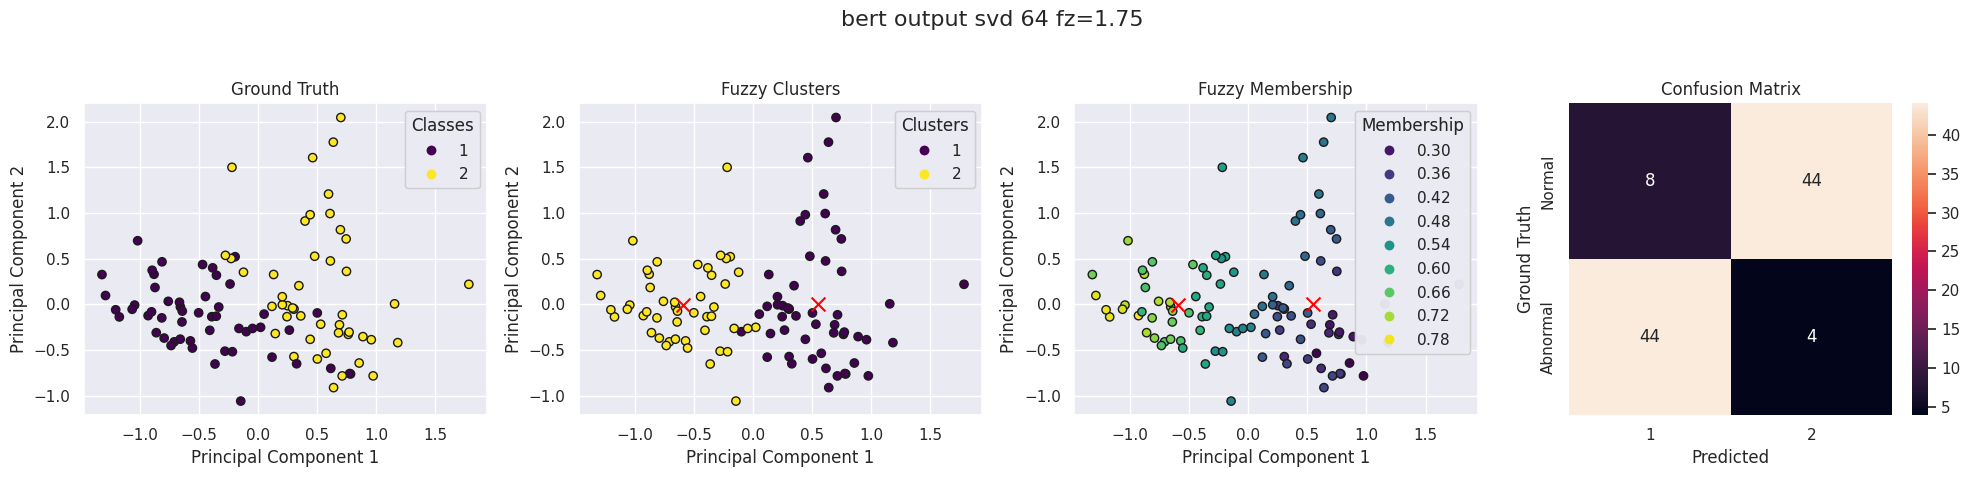

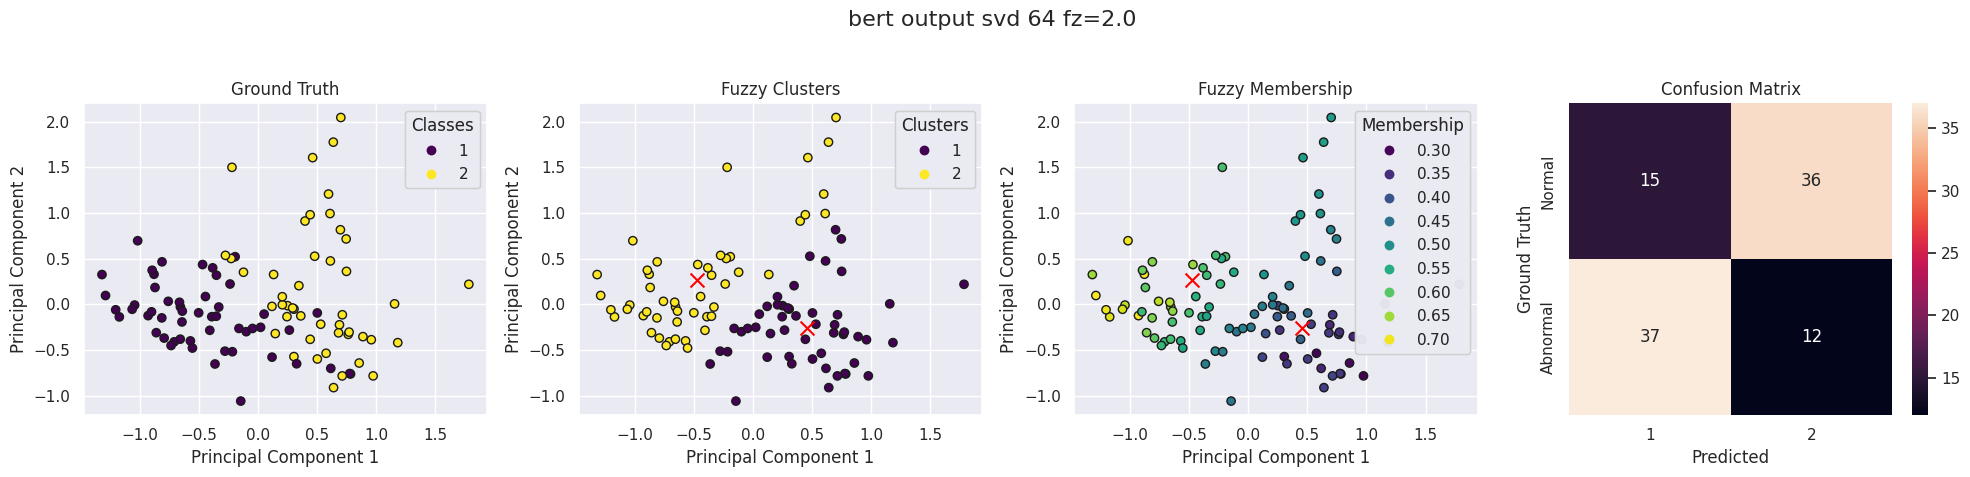

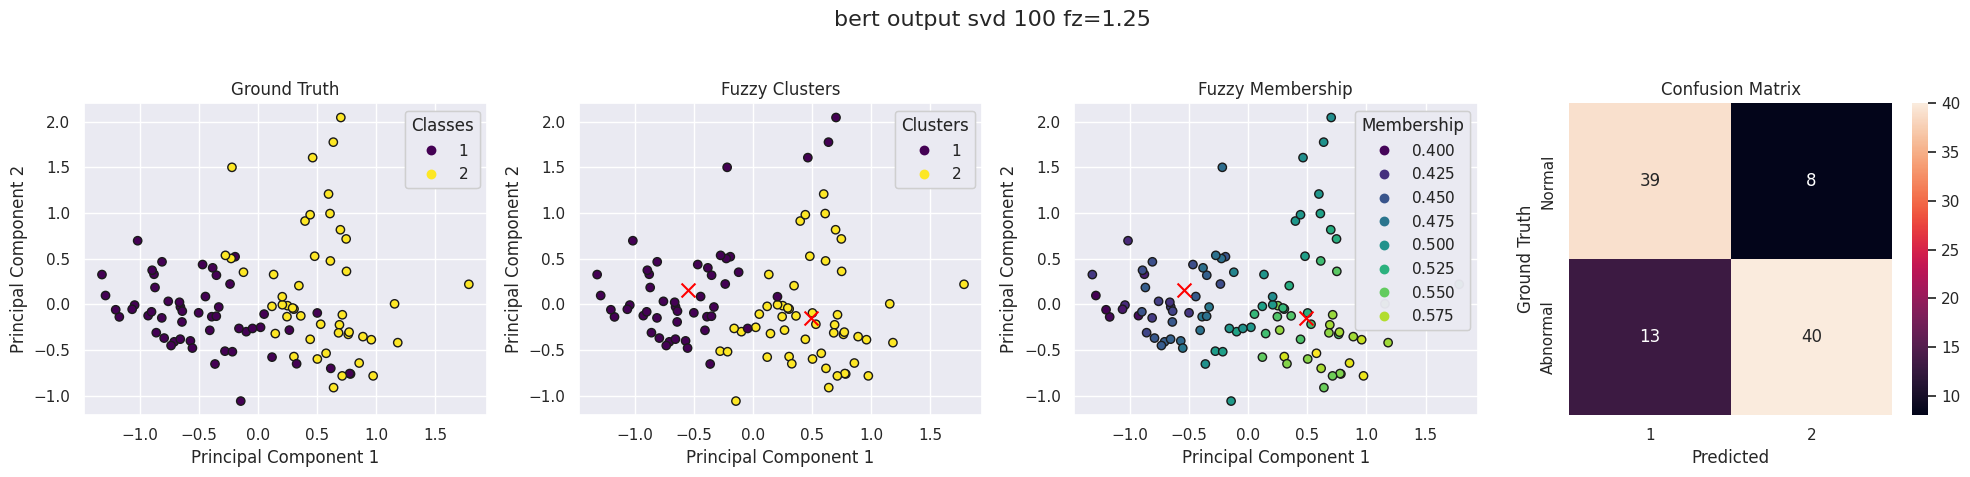

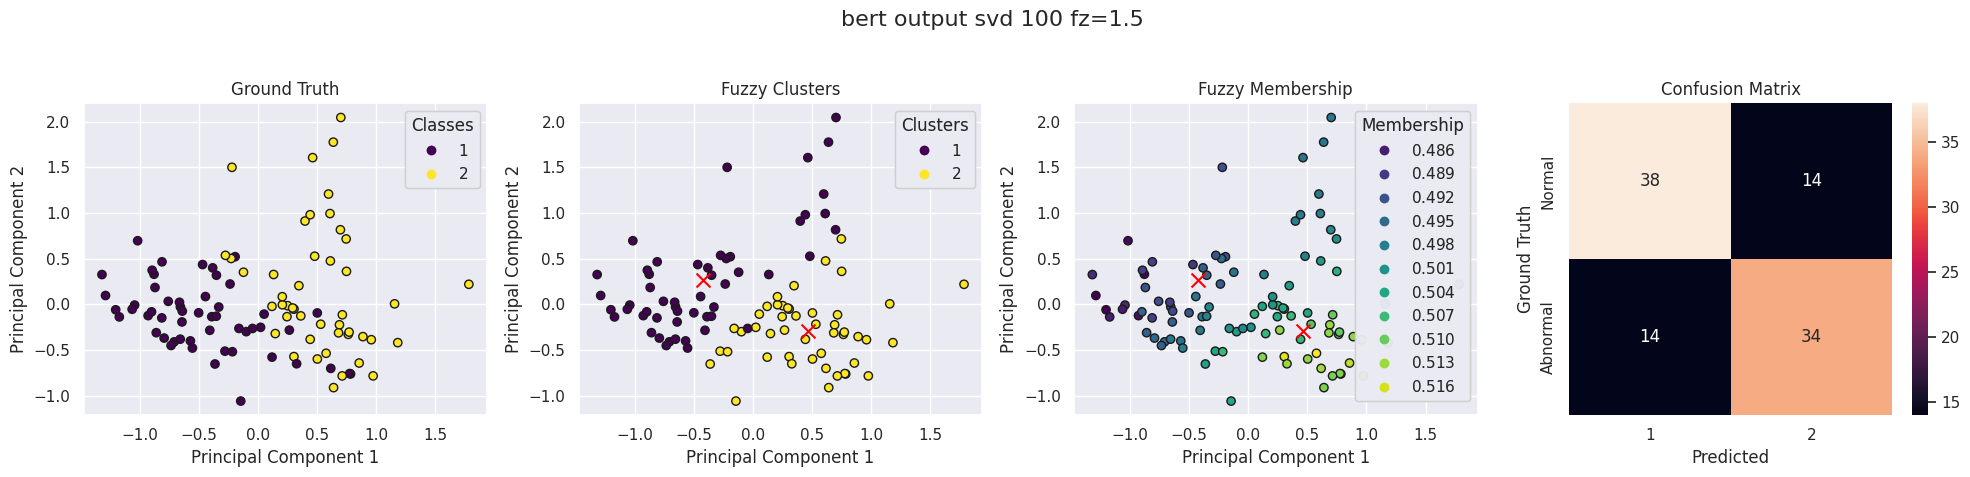

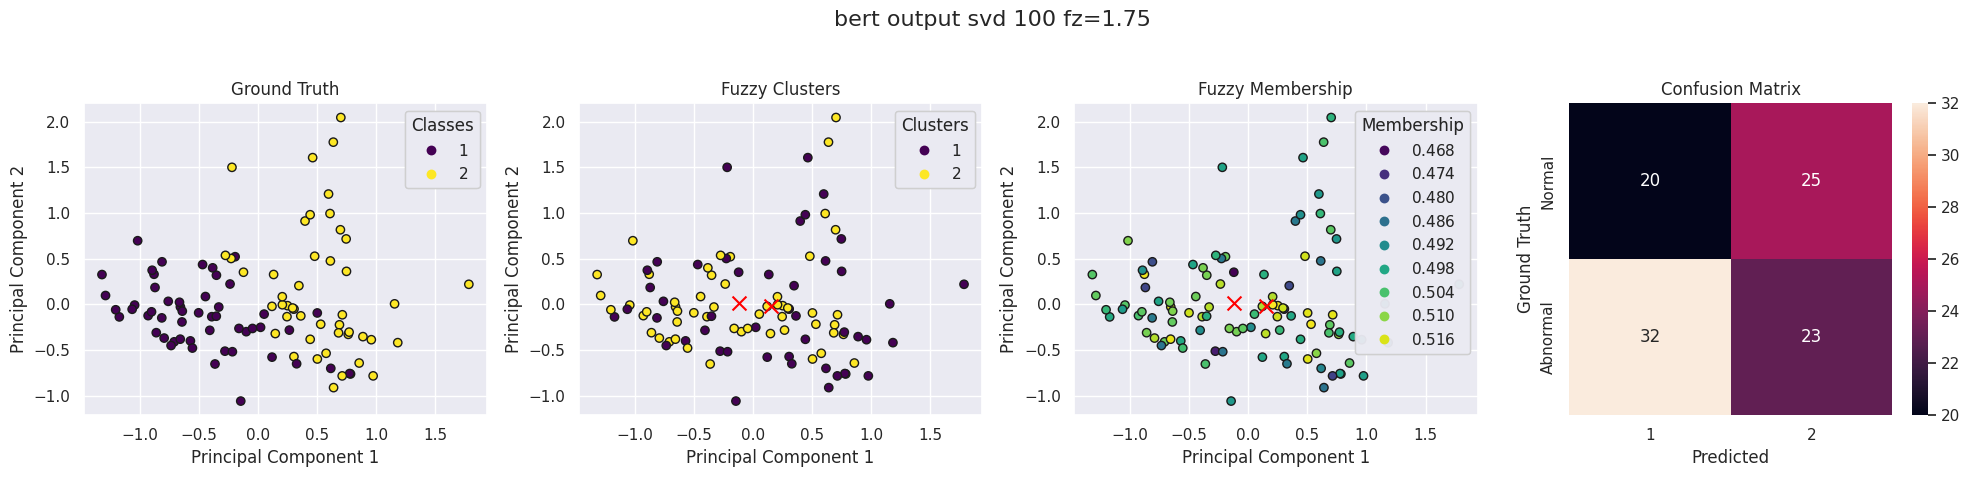

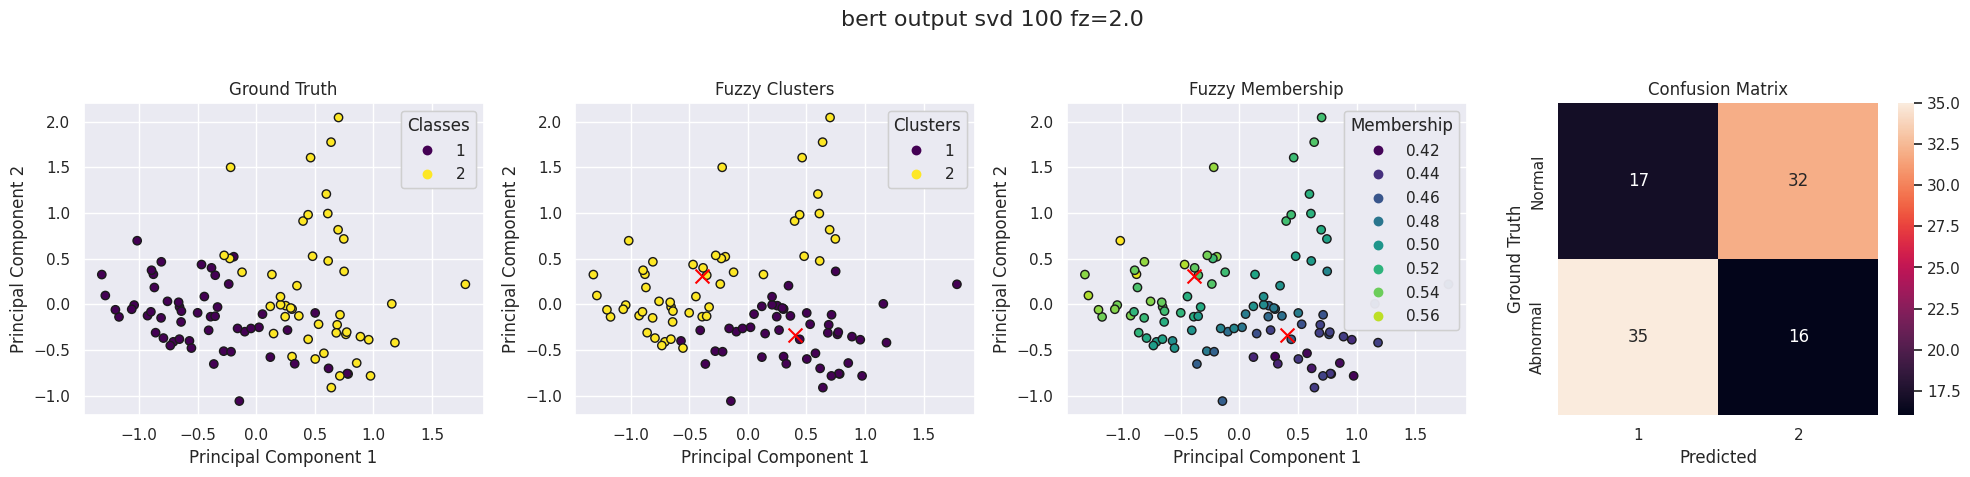

In [203]:
plot_names = ["bert output 768", "bert output pca 64", "bert_output pca 100", "bert output svd 64", "bert output svd 100"]

for (i, name) in enumerate(plot_names):
    for fz in fz_factors:
        plot_2d_charts(stacked_tensor, result_dict[(i, fz)], get_ground_truth_list(), name + " fz=" + str(fz))